<a href="https://colab.research.google.com/github/ferrari-leo/training/blob/main/practical_mab/mab_implementations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Create simulation environment

In [2]:
class Environment(object):
  def __init__(self, reward_probabilities, actual_rewards):
    if len(reward_probabilities) != len(actual_rewards):
      raise Exception(f'size of reward probabilities {len(reward_probabilities)} does not match size of actual rewards {len(actual_rewards)}')

    self.reward_probabilities = reward_probabilities
    self.actual_rewards = actual_rewards
    self.k_arms = len(actual_rewards)

  def choose_arm(self, arm):
    if arm < 0 or arm >= self.k_arms:
      raise Exception(f'arm must be between 0 and {self.k_arms - 1}')

    return self.actual_rewards[arm] if np.random.random() < self.reward_probabilities[arm] else 0.0

In [3]:
env = Environment(
    reward_probabilities=[0.62, 0.05, 0.87, 0.49],
    actual_rewards=[1.0, 1.0, 1.0, 1.0]
)

In [8]:
[env.choose_arm(3) for _ in range(10)]

[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]

# Incremental Average

In [12]:
time_steps = np.arange(1, 50)
weights = 1/time_steps

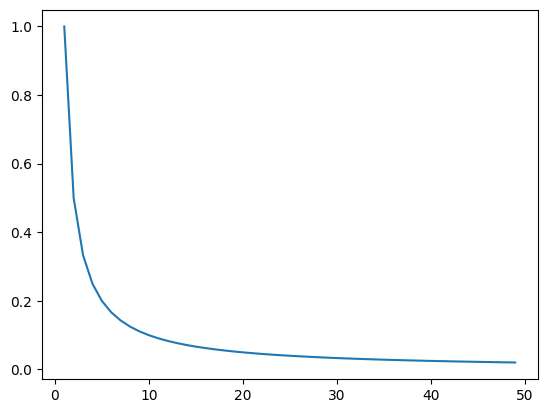

In [15]:
plt.plot(time_steps, weights);

# Implement a randomly behaving agent

In [18]:
class RandomAgent(object):

  def __init__(self, env, max_iterations = 500):
    self.env = env
    self.iterations = max_iterations

    self.q_values    = np.zeros(self.env.k_arms)
    self.arm_counts  = np.zeros(self.env.k_arms)
    self.arm_rewards = np.zeros(self.env.k_arms)

    self.rewards = [0.0]
    self.cum_rewards = [0.0]

  def act(self):
    for i in range(self.iterations):
      arm = np.random.choice(self.env.k_arms)
      reward = self.env.choose_arm(arm)

      self.arm_counts[arm] += 1
      self.arm_rewards[arm] += reward

      # use simple incremental average
      self.q_values[arm] += (1 / self.arm_counts[arm]) * (reward - self.q_values[arm])
      self.rewards.append(reward)
      self.cum_rewards.append(sum(self.rewards) / len(self.rewards))

    return {
        'arm_counts' : self.arm_counts,
        'rewards' : self.rewards,
        'cum_rewards' : self.cum_rewards
    }

In [19]:
test_env = Environment(
    reward_probabilities=[0.62, 0.05, 0.87, 0.49],
    actual_rewards=[1.0, 1.0, 1.0, 1.0]
)

random_agent = RandomAgent(test_env)

random_agent_result = random_agent.act()

In [21]:
total_rewards = sum(random_agent_result['rewards'])
print(total_rewards)

231.0


<BarContainer object of 4 artists>

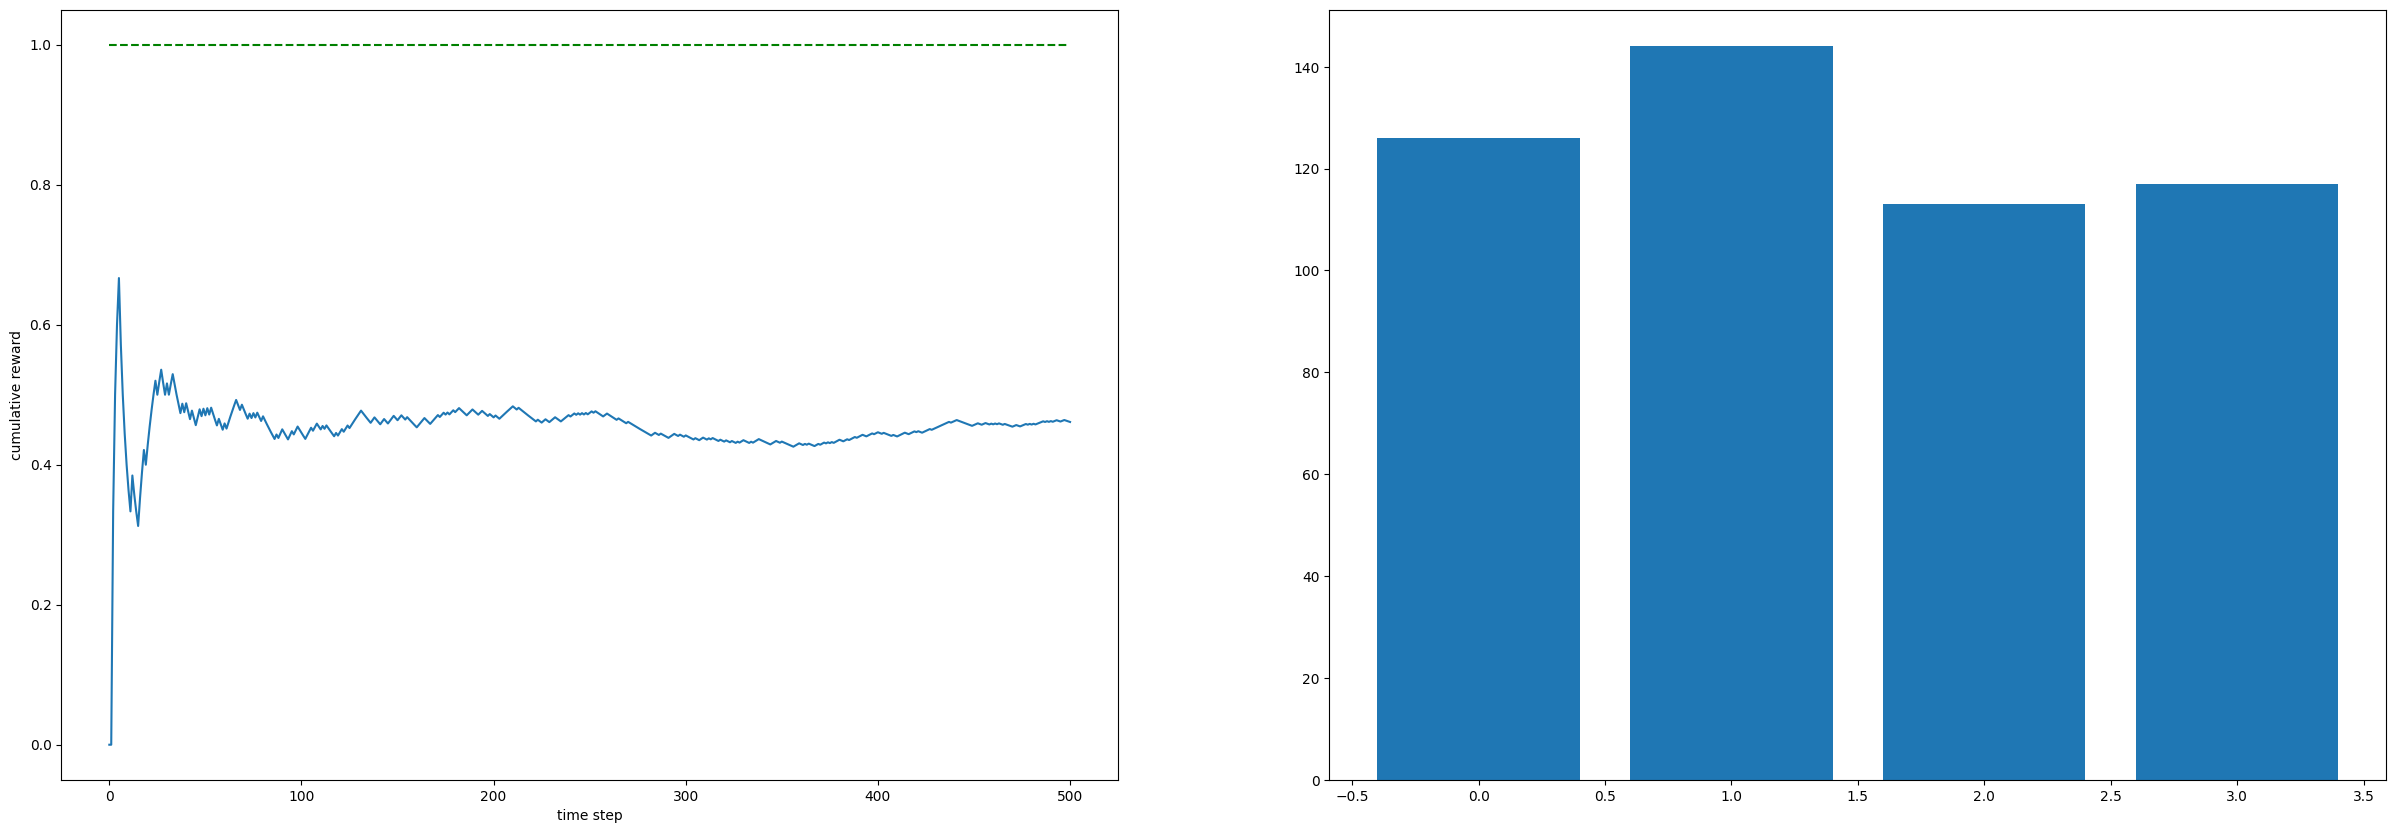

In [26]:
cum_rewards = random_agent_result['cum_rewards']
arm_counts = random_agent_result['arm_counts']

fig = plt.figure(figsize = [30,10])

ax1 = fig.add_subplot(121)
ax1.plot([1.0 for _ in range(random_agent.iterations)], 'g--', label = 'target cumulative reward')
ax1.plot(cum_rewards, label = 'cumulative rewards')
ax1.set_xlabel('time step')
ax1.set_ylabel('cumulative reward')

ax2 = fig.add_subplot(122)
ax2.bar([i for i in range(len(arm_counts))], arm_counts)

In [27]:
random_agent.q_values

array([0.61904762, 0.02777778, 0.85840708, 0.44444444])

# Implement a greedy agent

In [28]:
class GreedyAgent(object):

  def __init__(self, env, max_iterations = 500):
    self.env = env
    self.iterations = max_iterations

    self.q_values    = np.zeros(self.env.k_arms)
    self.arm_counts  = np.zeros(self.env.k_arms)
    self.arm_rewards = np.zeros(self.env.k_arms)

    self.rewards = [0.0]
    self.cum_rewards = [0.0]

  def act(self):
    for i in range(self.iterations):
      arm = np.argmax(self.q_values)
      reward = self.env.choose_arm(arm)

      self.arm_counts[arm] += 1
      self.arm_rewards[arm] += reward

      # use simple incremental average
      self.q_values[arm] += (1 / self.arm_counts[arm]) * (reward - self.q_values[arm])
      self.rewards.append(reward)
      self.cum_rewards.append(sum(self.rewards) / len(self.rewards))

    return {
        'arm_counts' : self.arm_counts,
        'rewards' : self.rewards,
        'cum_rewards' : self.cum_rewards
    }

In [39]:
test_env = Environment(
    reward_probabilities=[0.62, 0.05, 0.87, 0.49],
    actual_rewards=[1.0, 1.0, 1.0, 1.0]
)

greedy_agent = GreedyAgent(test_env)

greedy_agent_result = greedy_agent.act()

In [40]:
total_rewards = sum(greedy_agent_result['rewards'])
print(total_rewards)

321.0


<BarContainer object of 4 artists>

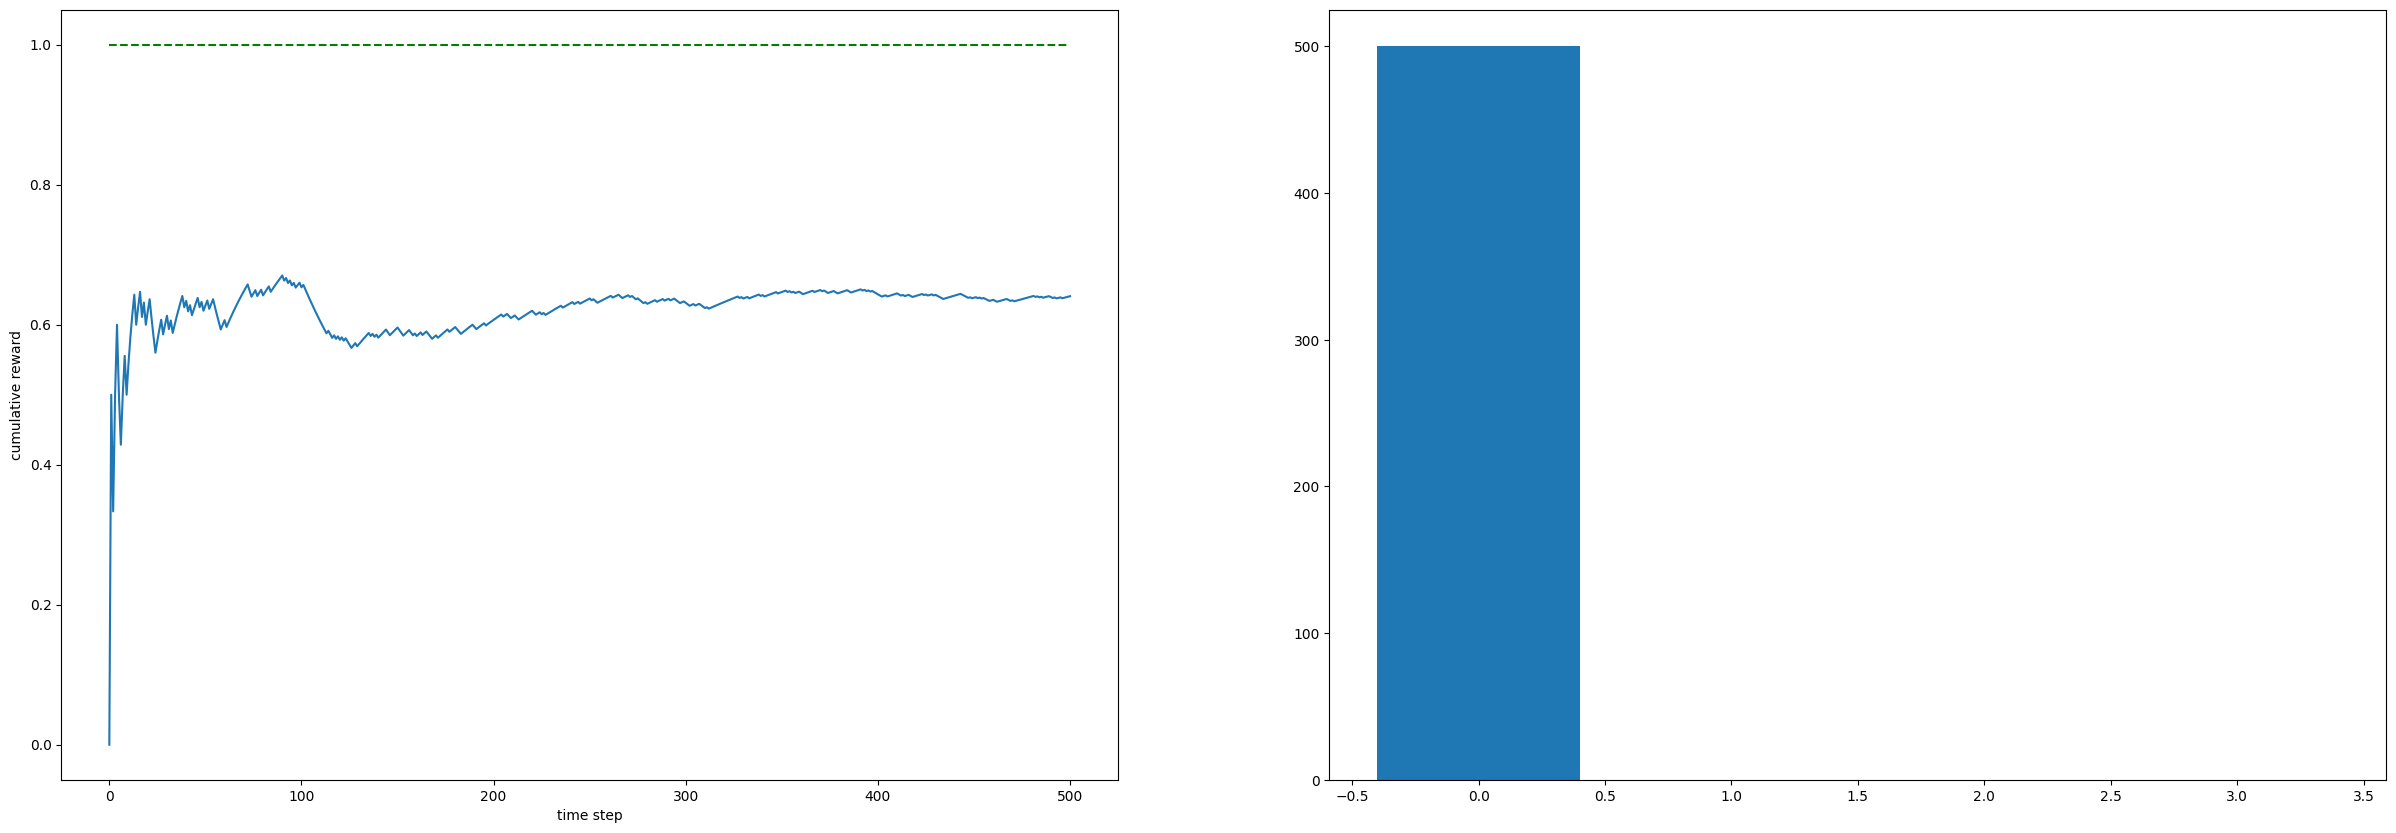

In [41]:
cum_rewards = greedy_agent_result['cum_rewards']
arm_counts = greedy_agent_result['arm_counts']

fig = plt.figure(figsize = [30,10])

ax1 = fig.add_subplot(121)
ax1.plot([1.0 for _ in range(greedy_agent.iterations)], 'g--', label = 'target cumulative reward')
ax1.plot(cum_rewards, label = 'cumulative rewards')
ax1.set_xlabel('time step')
ax1.set_ylabel('cumulative reward')

ax2 = fig.add_subplot(122)
ax2.bar([i for i in range(len(arm_counts))], arm_counts)

In [42]:
greedy_agent.q_values

array([0.642, 0.   , 0.   , 0.   ])

# Balance exploration & exploitation with epsilon-greedy agents

In [44]:
class EpsilonGreedyAgent(object):

  def __init__(self, env, max_iterations = 500, epsilon = 0.01):
    self.env = env
    self.iterations = max_iterations
    self.epsilon = epsilon

    self.q_values    = np.zeros(self.env.k_arms)
    self.arm_counts  = np.zeros(self.env.k_arms)
    self.arm_rewards = np.zeros(self.env.k_arms)

    self.rewards = [0.0]
    self.cum_rewards = [0.0]

  def act(self):
    for i in range(self.iterations):
      arm = np.random.choice(self.env.k_arms) if np.random.random() < self.epsilon else np.argmax(self.q_values)
      reward = self.env.choose_arm(arm)

      self.arm_counts[arm] += 1
      self.arm_rewards[arm] += reward

      # use simple incremental average
      self.q_values[arm] += (1 / self.arm_counts[arm]) * (reward - self.q_values[arm])
      self.rewards.append(reward)
      self.cum_rewards.append(sum(self.rewards) / len(self.rewards))

    return {
        'arm_counts' : self.arm_counts,
        'rewards' : self.rewards,
        'cum_rewards' : self.cum_rewards
    }

In [69]:
test_env = Environment(
    reward_probabilities=[0.62, 0.05, 0.87, 0.49],
    actual_rewards=[1.0, 1.0, 1.0, 1.0]
)

e_greedy_agent = EpsilonGreedyAgent(test_env, epsilon = 0.5)

e_greedy_agent_result = e_greedy_agent.act()

In [70]:
total_rewards = sum(e_greedy_agent_result['rewards'])
print(total_rewards)

343.0


<BarContainer object of 4 artists>

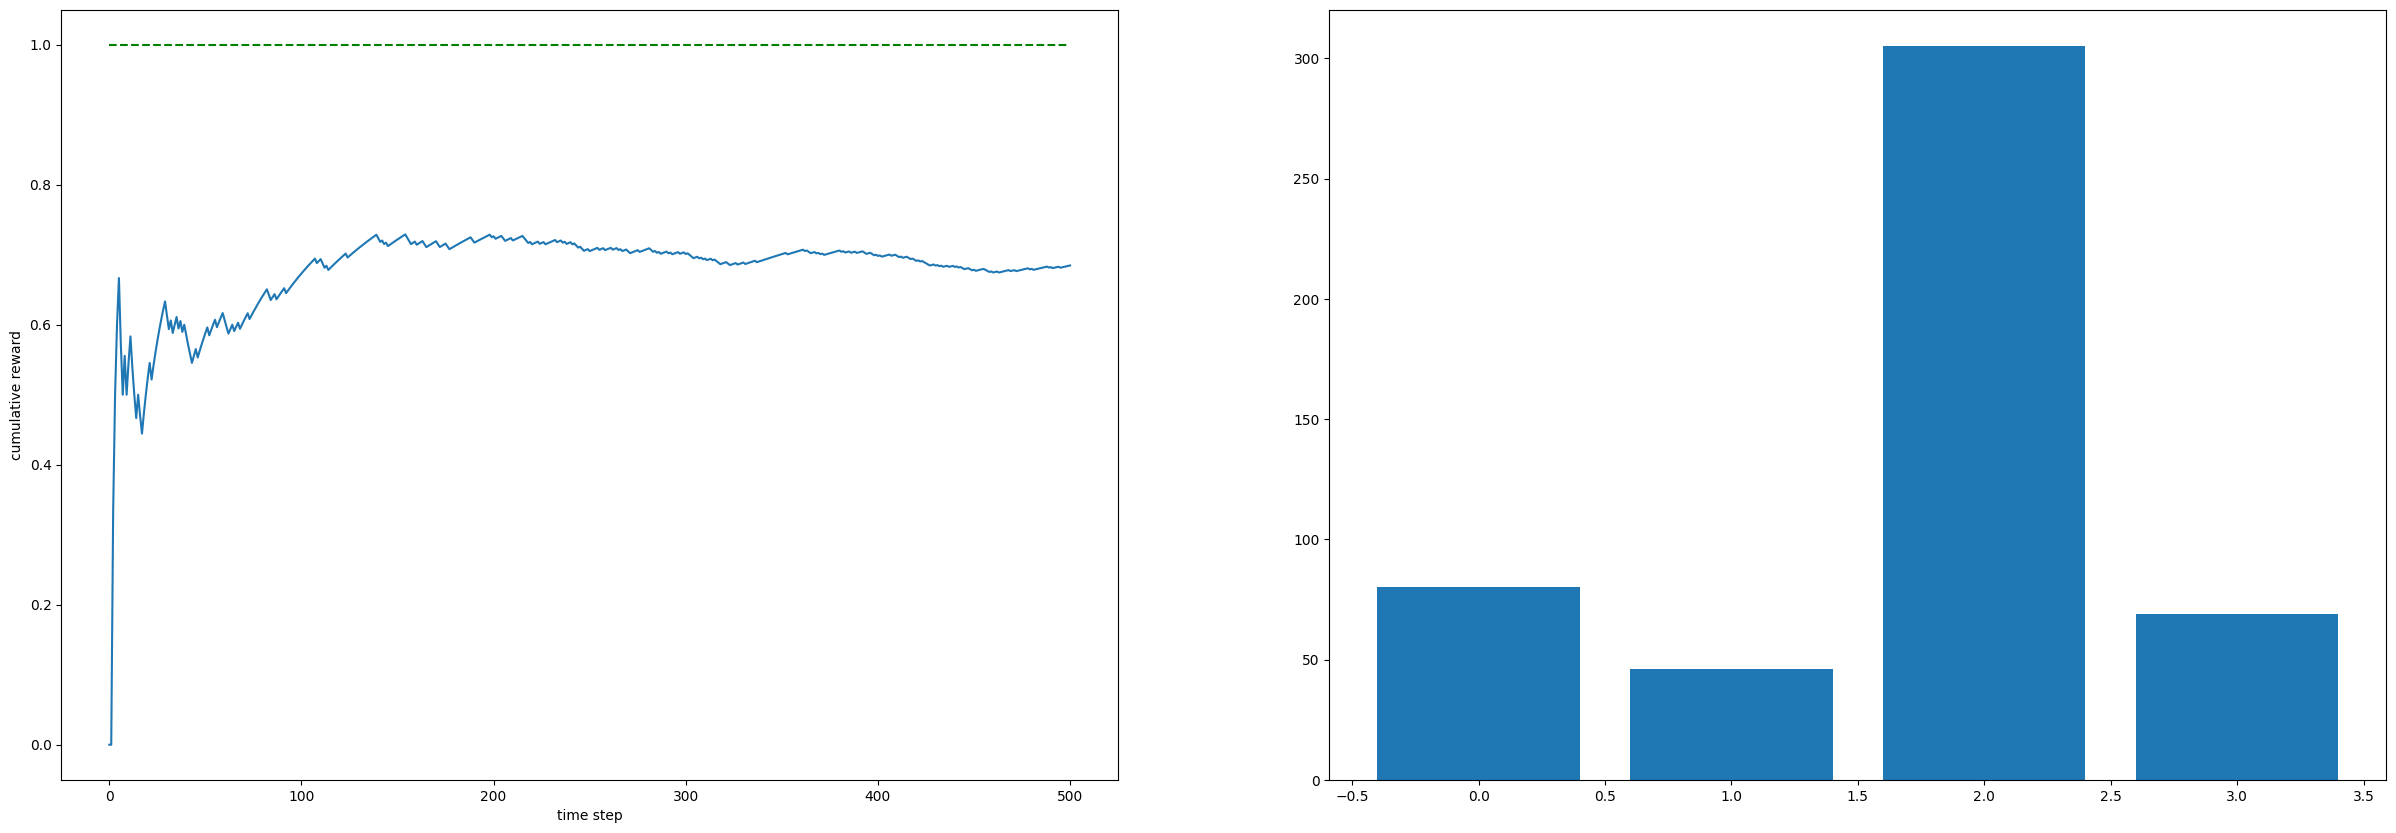

In [71]:
cum_rewards = e_greedy_agent_result['cum_rewards']
arm_counts = e_greedy_agent_result['arm_counts']

fig = plt.figure(figsize = [30,10])

ax1 = fig.add_subplot(121)
ax1.plot([1.0 for _ in range(e_greedy_agent.iterations)], 'g--', label = 'target cumulative reward')
ax1.plot(cum_rewards, label = 'cumulative rewards')
ax1.set_xlabel('time step')
ax1.set_ylabel('cumulative reward')

ax2 = fig.add_subplot(122)
ax2.bar([i for i in range(len(arm_counts))], arm_counts)

In [56]:
e_greedy_agent.q_values

array([0.65      , 0.        , 0.87828162, 0.        ])